# Setup

In [1]:
import asyncio
from collections import Counter
import json
import re
from pathlib import Path

from googletrans import Translator
from langdetect import detect, LangDetectException
import matplotlib.pyplot as plt
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import numpy as np
import polars as pl
from sklearn.preprocessing import MinMaxScaler
import spacy
from stopwordsiso import stopwords
from tqdm import tqdm
from tqdm.asyncio import tqdm_asyncio
from wordcloud import WordCloud

import utils
from utils import PATHS

In [2]:
nltk.download('vader_lexicon')
nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Tools

In [3]:
def extract_tokens(text: str) -> list[str]:
    """Firstly remove all non alphabetic characters, having in mind that
    there are Unicode characters. After tokenization we remove stopwords (ENG)
    and  remove all 1-2 chars lenghts words.

    Finally lemmatize tokens.
    """
    clean = re.sub(r"[\W]+", " ", text.lower())
    clean = re.sub(r"[\d]+", " ", clean)
    words = nltk.word_tokenize(clean)
    words = [w for w in words if w not in stopwords("en") and len(w) > 2]
    doc = nlp(" ".join(words))
    return [token.lemma_.lower() for token in doc if token.is_alpha]

# Load

In [4]:
with (PATHS.data / "games_reviews.json").open("rb") as f:
    data = json.load(f)

In [5]:
example_data = data[0]

In [6]:
example_data.keys()

dict_keys(['title', 'game_details', 'game_stats', 'game_reviews'])

In [7]:
import nltk
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [8]:
Counter(extract_tokens(example_data["game_details"]["long_description"]))

Counter({'brass': 5,
         'industry': 5,
         'action': 5,
         'birmingham': 4,
         'game': 4,
         'build': 3,
         'network': 3,
         'canal': 3,
         'rail': 3,
         'story': 2,
         'predecessor': 2,
         'develop': 2,
         'establish': 2,
         'era': 2,
         'vps': 2,
         'tile': 2,
         'original': 2,
         'sell': 2,
         'loan': 2,
         'card': 2,
         'wild': 2,
         'economic': 1,
         'strategy': 1,
         'sequel': 1,
         'martin': 1,
         'wallace': 1,
         'masterpiece': 1,
         'tell': 1,
         'compete': 1,
         'entrepreneur': 1,
         'industrial': 1,
         'revolution': 1,
         'offer': 1,
         'arc': 1,
         'experience': 1,
         'effort': 1,
         'exploit': 1,
         'market': 1,
         'demand': 1,
         'play': 1,
         'half': 1,
         'win': 1,
         'score': 1,
         'count': 1,
         'flip': 1,
   

In [9]:
def recognize_language(text: str) -> str:
    try:
        lang = detect(text)
    except LangDetectException:
        lang = "en" #TODO: set special flag
    return lang

@utils.with_pickle_async()
async def translate_multiple(texts: list[str], lang_from: list[str], lang_to: list[str]) -> list[str]:
    async with Translator() as translator:
        async def translate_one(text, src, dest):
            t = await translator.translate(text=text, src=src, dest=dest)
            return t.text
        return await tqdm_asyncio.gather(
            *(translate_one(text, from_, to_) for text, from_, to_ in zip(texts, lang_from, lang_to, strict=True))
        )

In [10]:
example_game_reviews = [info["review"] for info in example_data["game_reviews"]]
from_langs =  [recognize_language(r) for r in example_game_reviews]
translactions = await translate_multiple(example_game_reviews, from_langs, ["en"] * len(from_langs), pickle_path=PATHS.pickles / "example_translations")

In [12]:
def extract_tokens(text: str) -> list[str]:
    """Firstly remove all non alphabetic characters, having in mind that
    there are Unicode characters. After tokenization we remove stopwords (ENG+PL)
    and  remove all 1-2 chars lenghts words.

    Finally lemmatize tokens.
    """
    clean = re.sub(r"[\W]+", " ", text.lower())
    clean = re.sub(r"[\d]+", " ", clean)
    words = nltk.word_tokenize(clean)
    words = [w for w in words if w not in (word_difficulty.STOPWORDS_PL | word_difficulty.STOPWORDS_EN) and len(w) > 2]
    doc = nlp(" ".join(words))
    return [token.lemma_.lower() for token in doc if token.is_alpha]

### Sentiment analysis

In [13]:
analyzer = SentimentIntensityAnalyzer()

def get_sentiment(text):
    scores = analyzer.polarity_scores(text)
    if scores['compound'] >= 0.05:
        sentiment = 1
    elif scores['compound'] <= -0.05:
        sentiment = -1
    else:
        sentiment = 0
    return sentiment

In [ ]:
sentiments = list(map(get_sentiment, translactions))


# Unsupervised Text Classification

In [15]:
import pandas as pd

In [16]:
import polars as pl
from sklearn.datasets import fetch_20newsgroups

# load data
train = fetch_20newsgroups(subset='train', shuffle=False)
test = fetch_20newsgroups(subset='test', shuffle=False)

# parse data to pandas DataFrames
newsgroup_test = pd.DataFrame({'article':test.data, 'class_index':test.target})
newsgroup_train = pd.DataFrame({'article':train.data, 'class_index':train.target})

# load labels with keywords
# labels = pd.read_csv('20newsgroups_keywords.csv',sep=';')
labels = pd.DataFrame({
    "class_index": range(len(train.target_names)),
    "class_name": train.target_names
})

# Sentiment analysis

In [17]:
import json
import re


### Loading

In [18]:
def clean_for_sentiment(text):
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

In [19]:
with open("data//games_reviews.json", "r", encoding="utf-8") as f:
    data = json.load(f)

In [20]:
rows = []
for game in data:
    game_title = game["title"]
    game_weight = float(game["game_details"]["params"]["weight"])
    avg_game_rating = game["game_stats"]["avg_rating"]

    for review in game["game_reviews"]:
        text = review.get("review", "").strip()

        # skip empty or useless reviews
        if len(text) < 20:
            continue
        rows.append({
            "game_title": game_title,
            "game_weight": game_weight,
            "avg_game_rating": avg_game_rating,
            "review_text": text,
            "review_rating": review.get("rating"),
            "is_owner": review.get("is_owner"),
            "review_date": review.get("date")
        })

df = pd.DataFrame(rows)

### Language detection - commented, long

In [21]:
def safe_lang_detect(text):
    try:
        return recognize_language(text)
    except:
        return "unknown"

#df["lang"] = df["review_text"].apply(safe_lang_detect)
#to_translate = df[df["lang"] != "en"]
#df = df[df["lang"] == "en"]

In [22]:
async def translate_reviews(df):
    reviews = df["review_text"].tolist()
    from_langs = df["lang"].tolist()

    translations = await translate_multiple(
        reviews,
        from_langs,
        ["en"] * len(from_langs),
        pickle_path=PATHS.pickles / "df_translations"
    )
    return translations

In [23]:
from googletrans import Translator

def translate_multiple(texts, src_langs, tgt_langs):
    translator = Translator()
    results = []

    for text, src, tgt in zip(texts, src_langs, tgt_langs):
        try:
            if src == "en":
                results.append(text)
            else:
                t = translator.translate(text, src=src, dest=tgt)
                results.append(t.text)
        except Exception:
            results.append(text)  # fallback

    return results

In [24]:
# translations = translate_multiple(
#     reviews,
#     from_langs,
#     ["en"] * len(from_langs)
# )

#df.loc[to_translate.index, "review_en"] = translations

## Sentiment analysis
textblob - chyba niepotrzebne, jeśli za mało na prezentacji to może porównanie?

In [25]:
df["review_date"] = pd.to_datetime(df["review_date"], errors="coerce")

In [26]:
df = df[df["review_rating"].notna()]

In [27]:
print("Total reviews:", len(df))
print("Unique games:", df["game_title"].nunique())
print("Average review length:",
      df["review_text"].str.len().mean())

Total reviews: 360611
Unique games: 100
Average review length: 251.24366977158212


In [28]:
def vader_label(compound):
    if compound >= 0.05:
        return "positive"
    elif compound <= -0.05:
        return "negative"
    else:
        return "neutral"
def textblob_label(polarity, pos=0.05, neg=-0.05):
    if polarity > pos:
        return "positive"
    elif polarity < neg:
        return "negative"
    else:
        return "neutral"


In [29]:
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

df["sentiment_scores"] = df["review_text"].apply(sia.polarity_scores)
df["compound"] = df["sentiment_scores"].apply(lambda x: x["compound"])
df["sentiment_label"] = df["compound"].apply(vader_label)

In [33]:
# Zmieniamy na tb_polarity, żeby zgadzało się z wywołaniem niżej
df["tb_polarity"] = df["review_text"].apply(
    lambda x: TextBlob(x).sentiment.polarity)

df["tb_subjectivity"] = df["review_text"].apply(
    lambda x: TextBlob(x).sentiment.subjectivity)

# Teraz to zadziała bez błędu
df["tb_label"] = df["tb_polarity"].apply(textblob_label)

### Plots

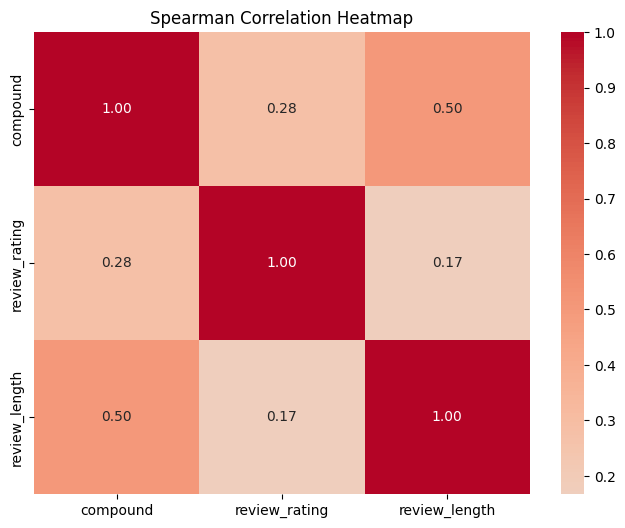

In [35]:
# 1. Najpierw stwórz brakującą kolumnę
df["review_length"] = df["review_text"].str.len()

# 2. Teraz Twoja lista i korelacja zadziałają
numeric_cols = [
    "compound",
    "review_rating",
    "review_length"
]

corr_matrix = df[numeric_cols].corr(method="spearman")

# 3. Wyświetlenie heatmapy
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Spearman Correlation Heatmap")
plt.show()

In [36]:
# reviews that may be misclassified
contradictions = df[
    ((df["review_rating"] >= 8) & (df["compound"] < 0)) |
    ((df["review_rating"] <= 3) & (df["compound"] > 0))
]
contradictions

,game_title,game_weight,avg_game_rating,review_text,review_rating,is_owner,review_date,sentiment_scores,compound,sentiment_label,tb_sentiment,tb_subjectivity,tb_polarity,tb_label,review_length
17,Brass: Birmingham,3.87,8.572,La primera partida había sido media trabada. E...,9.0,False,2019-08-27 09:30:40,"{'neg': 0.034, 'neu': 0.943, 'pos': 0.024, 'co...",-0.2500,negative,0.375000,0.750000,0.375000,positive,1151
22,Brass: Birmingham,3.87,8.572,I enjoy Lancashire and want to add this one to...,0.0,False,2024-11-08 11:08:43,"{'neg': 0.0, 'neu': 0.727, 'pos': 0.273, 'comp...",0.5423,positive,0.400000,0.500000,0.400000,positive,75
26,Brass: Birmingham,3.87,8.572,+ Engaging tactics and strategy\n+ Agonizing d...,8.0,False,2025-08-24 07:20:11,"{'neg': 0.147, 'neu': 0.757, 'pos': 0.096, 'co...",-0.3182,negative,0.110714,0.492857,0.110714,positive,176
37,Brass: Birmingham,3.87,8.572,"In my opinion, Lancashire is much better.\n\nL...",0.0,False,2018-10-26 17:42:27,"{'neg': 0.025, 'neu': 0.777, 'pos': 0.198, 'co...",0.8835,positive,0.106071,0.581071,0.106071,positive,385
55,Brass: Birmingham,3.87,8.572,La primera partida había sido media trabada. E...,9.0,False,2019-08-27 09:30:40,"{'neg': 0.034, 'neu': 0.943, 'pos': 0.024, 'co...",-0.2500,negative,0.375000,0.750000,0.375000,positive,1151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360591,Final Girl,2.74,8.248,Thematically amazing. Very luck based and the ...,0.0,True,2022-11-30 01:59:46,"{'neg': 0.133, 'neu': 0.588, 'pos': 0.279, 'co...",0.8130,positive,0.311111,0.711111,0.311111,positive,235
360593,Final Girl,2.74,8.248,[Gracze] 1\n[Czas] 20-60m\n[Wiek] 14+\nS: Full...,10.0,True,2024-06-10 17:44:03,"{'neg': 0.262, 'neu': 0.738, 'pos': 0.0, 'comp...",-0.4278,negative,0.350000,0.550000,0.350000,positive,50
360602,Final Girl,2.74,8.248,Played twice. Solo only,0.0,True,2023-02-13 18:32:47,"{'neg': 0.0, 'neu': 0.556, 'pos': 0.444, 'comp...",0.3400,positive,0.000000,1.000000,0.000000,neutral,23
360603,Final Girl,2.74,8.248,https://www.vanrydergames.com/new-products/fin...,0.0,True,2022-01-05 11:16:12,"{'neg': 0.07, 'neu': 0.832, 'pos': 0.098, 'com...",0.5204,positive,0.033333,0.875000,0.033333,neutral,461


In [37]:
# podział na tytuły gier
game_sentiment = (
    df.groupby("game_title")
      .agg(
          mean_sentiment=("compound", "mean"),
          game_weight=("game_weight", "first"),
          review_count=("compound", "count")
      )
      .reset_index()
)
game_sentiment


,game_title,mean_sentiment,game_weight,review_count
0,7 Wonders Duel,0.433657,2.23,9244
1,A Feast for Odin,0.414738,3.86,3529
2,Age of Innovation,0.397365,4.26,776
3,Agricola,0.409917,3.64,10583
4,Agricola (Revised Edition),0.368609,3.44,1956
...,...,...,...,...
95,Viticulture Essential Edition,0.420784,2.90,5038
96,Voidfall,0.389946,4.59,1007
97,War of the Ring: Second Edition,0.356258,4.22,3049
98,Wingspan,0.496487,2.48,10244


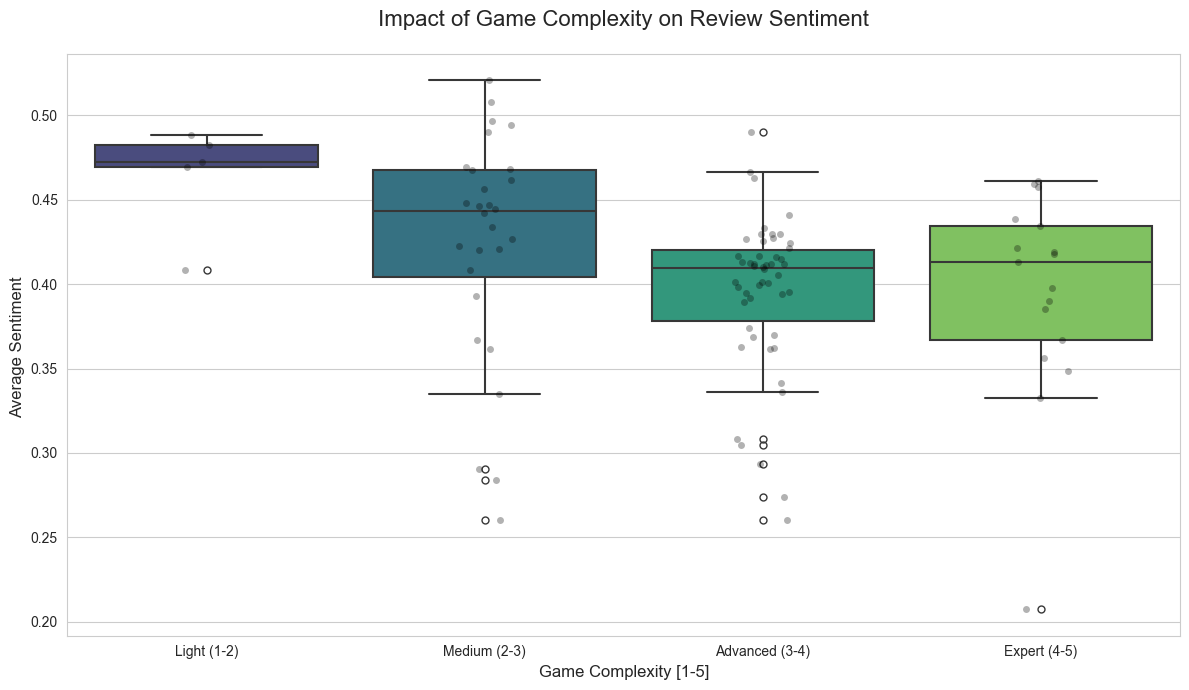

In [91]:
plt.figure(figsize=(12, 7))
sns.set_style("whitegrid")

# Create the binning variable to use as hue and avoid the FutureWarning
game_sentiment['difficulty_range'] = pd.cut(game_sentiment["game_weight"], [1, 2, 3, 4, 5])

# 2. Boxplot with corrected parameters
ax = sns.boxplot(
    data=game_sentiment,
    x='difficulty_range',
    y="mean_sentiment",
    hue='difficulty_range',  # Assigned hue to avoid warning
    palette="viridis",
    legend=False,            # Hide legend as x-axis already provides labels
    linewidth=1.5,
    fliersize=5
)

# 3. Add individual game points (Stripplot)
sns.stripplot(
    data=game_sentiment,
    x='difficulty_range',
    y="mean_sentiment",
    color="black",
    alpha=0.3,
    jitter=True
)

# 4. English Labels and Titles
plt.title("Impact of Game Complexity on Review Sentiment", fontsize=16, pad=20)
plt.xlabel("Game Complexity [1-5]", fontsize=12)
plt.ylabel("Average Sentiment ", fontsize=12)

# Custom X-axis labels in English
plt.xticks(
    ticks=[0, 1, 2, 3], 
    labels=['Light (1-2)', 'Medium (2-3)', 'Advanced (3-4)', 'Expert (4-5)']
)

plt.tight_layout()
plt.show()

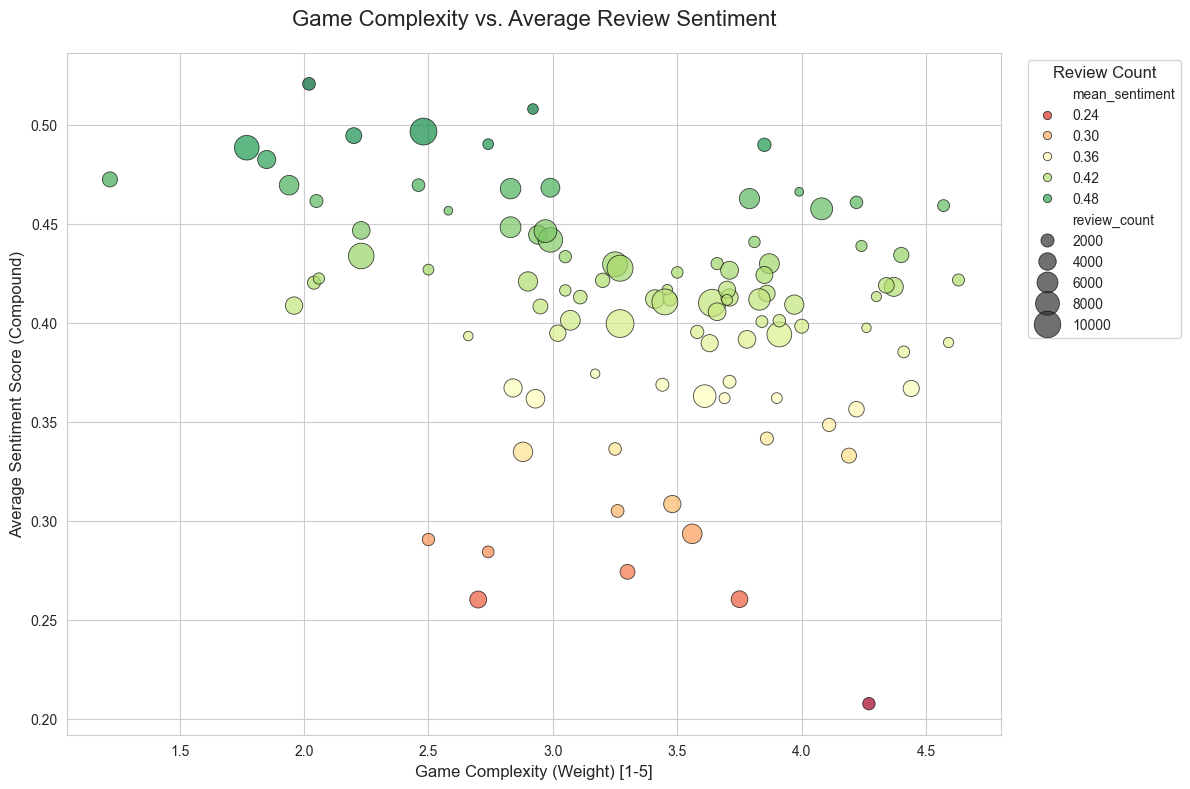

In [92]:

# 1. Setup
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

# 2. Enhanced Scatterplot
ax = sns.scatterplot(
    data=game_sentiment,
    x="game_weight",
    y="mean_sentiment",
    size="review_count",
    hue="mean_sentiment", # Color points by sentiment for better intuition
    palette="RdYlGn",     # Red-Yellow-Green scale
    sizes=(40, 400),      # Minimum and maximum bubble size
    alpha=0.7,            # Transparency to see overlapping points
    edgecolor="black"     # Better contrast for individual dots
)

# 3. Titles and Labels (English)
plt.title("Game Complexity vs. Average Review Sentiment", fontsize=16, pad=20)
plt.xlabel("Game Complexity (Weight) [1-5]", fontsize=12)
plt.ylabel("Average Sentiment Score (Compound)", fontsize=12)

# 4. Legend customization
plt.legend(title="Review Count", title_fontsize='12', loc='upper right', bbox_to_anchor=(1.2, 1))

plt.tight_layout()
plt.show()

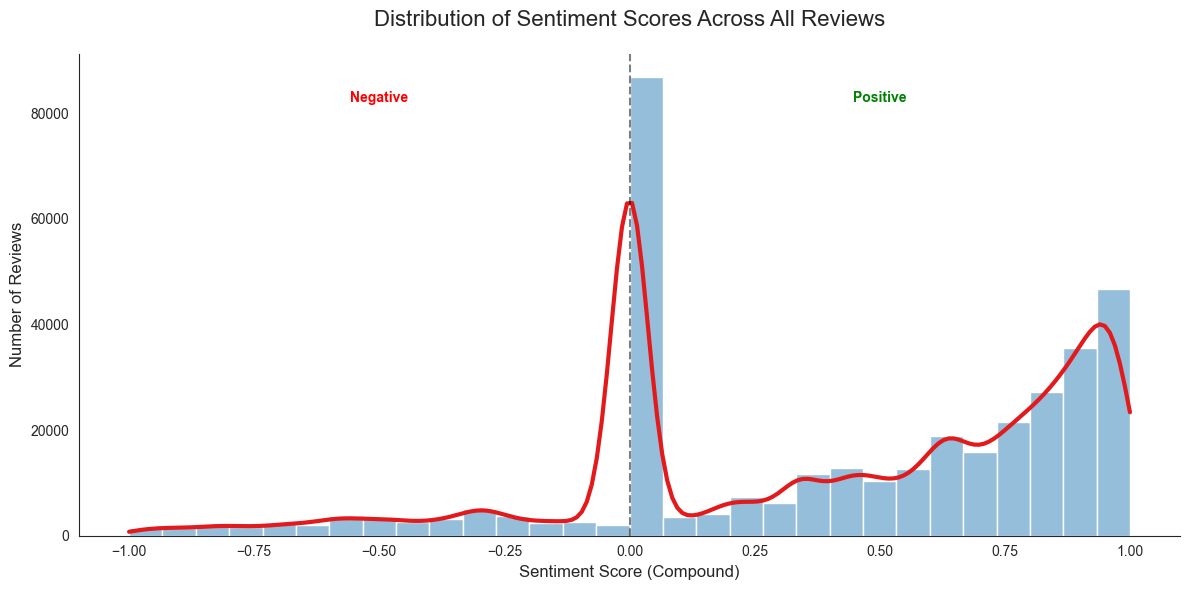

In [93]:

# 1. Setup
plt.figure(figsize=(12, 6))
sns.set_style("white") # Czyste białe tło

# 2. Histogram with styling
# Używamy koloru teal/blue dla profesjonalnego wyglądu
ax = sns.histplot(
    df["compound"], 
    bins=30, 
    kde=True, 
    color="#2c7fb8", 
    edgecolor="white",
    linewidth=1
)

# 3. Customizing the KDE line
ax.lines[0].set_color('#e31a1c') # Zmieniamy kolor linii trendu na czerwony dla kontrastu
ax.lines[0].set_linewidth(3)

# 4. English Labels and Titles
plt.title("Distribution of Sentiment Scores Across All Reviews", fontsize=16, pad=20)
plt.xlabel("Sentiment Score (Compound)", fontsize=12)
plt.ylabel("Number of Reviews", fontsize=12)

# Dodatkowe oznaczenia dla czytelności
plt.axvline(0, color='black', linestyle='--', alpha=0.5) # Linia oddzielająca negatyw od pozytywu
plt.text(-0.5, plt.ylim()[1]*0.9, "Negative", color='red', fontweight='bold', ha='center')
plt.text(0.5, plt.ylim()[1]*0.9, "Positive", color='green', fontweight='bold', ha='center')

sns.despine() # Usuwa górną i prawą ramkę
plt.tight_layout()
plt.show()

<Axes: xlabel='rating_bin', ylabel='compound'>

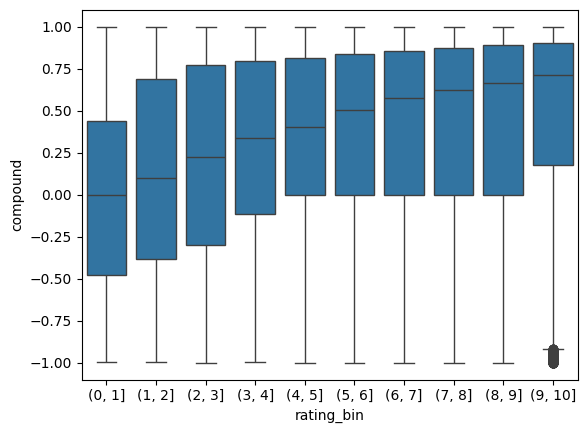

In [41]:
# given rating vs sentiment
df["rating_bin"] = pd.cut(
    df["review_rating"],
    bins=np.arange(11)
)

sns.boxplot(data=df, x="rating_bin", y="compound")

C:\Users\Dell\AppData\Local\Temp\ipykernel_3856\1627446064.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["rating_group", "sentiment_label"])


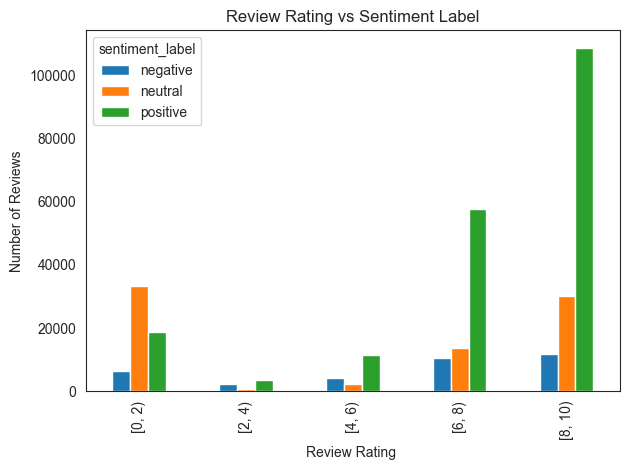

In [94]:
# same but just label - > clearer plot?
df["rating_group"] = pd.cut(
    df["review_rating"],
    bins=range(int(df["review_rating"].min()),
               int(df["review_rating"].max()) + 2, 2),
    right=False
)
counts = (
    df.groupby(["rating_group", "sentiment_label"])
      .size()
      .unstack(fill_value=0)
)
counts.plot(kind="bar")

plt.xlabel("Review Rating ")
plt.ylabel("Number of Reviews")
plt.title("Review Rating vs Sentiment Label")
plt.tight_layout()
plt.show()

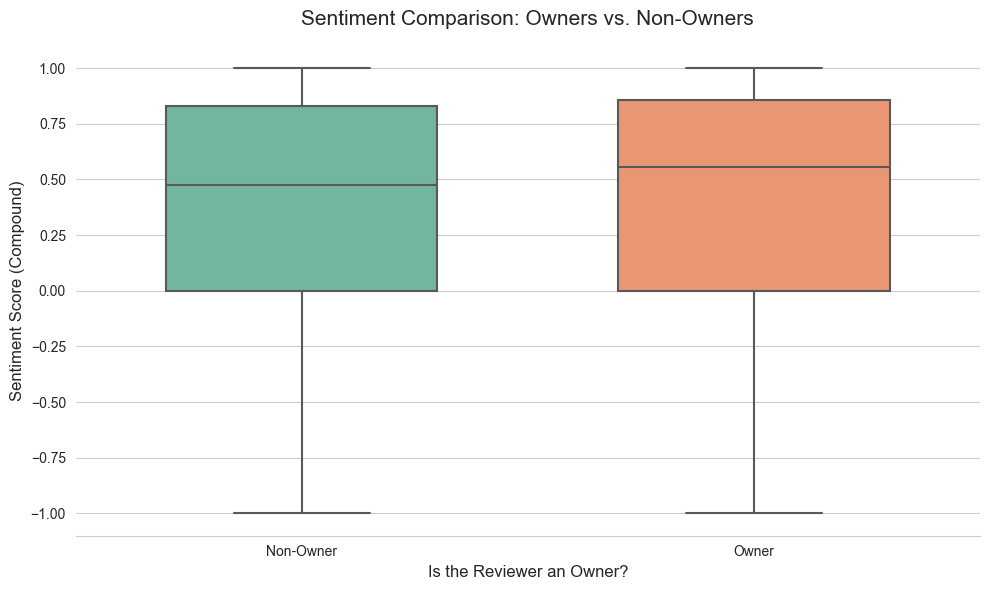

In [95]:

# 1. Setup
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# 2. Enhanced Boxplot
ax = sns.boxplot(
    data=df, 
    x="is_owner", 
    y="compound", 
    hue="is_owner",         # Added hue to follow new Seaborn standards
    palette="Set2",         # Aesthetic color palette
    legend=False, 
    width=0.6,
    linewidth=1.5,
    fliersize=4             # Size of outliers
)

# 3. Adding English Labels
plt.title("Sentiment Comparison: Owners vs. Non-Owners", fontsize=15, pad=15)
plt.xlabel("Is the Reviewer an Owner?", fontsize=12)
plt.ylabel("Sentiment Score (Compound)", fontsize=12)

# Customizing X-axis labels for clarity
plt.xticks(ticks=[0, 1], labels=["Non-Owner", "Owner"])

sns.despine(left=True) # Cleaner look
plt.tight_layout()
plt.show()

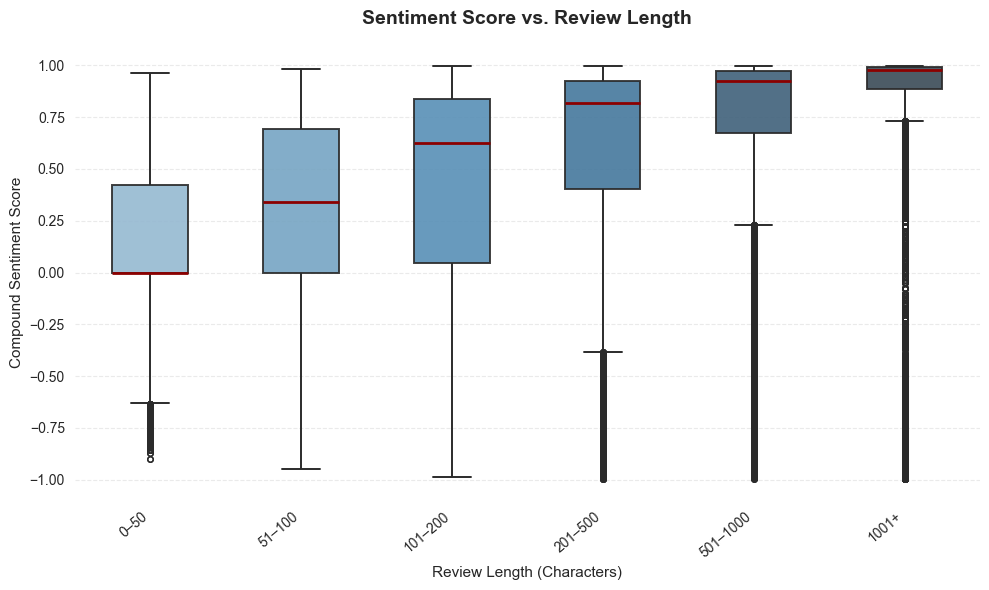

In [99]:

df["length_bin"] = pd.cut(
    df["review_length"],
    bins=[0, 50, 100, 200, 500, 1000, 5000],
    labels=["0–50", "51–100", "101–200", "201–500", "501–1000", "1001+"]
)

# 2. Setup and Style
plt.figure(figsize=(10, 6))
sns.set_style("white")

# 3. Plotting with fix for FutureWarning (assigning hue)
sns.boxplot(
    data=df,
    x="length_bin",
    y="compound",
    hue="length_bin",      # Assigning hue to x variable
    palette="Blues_d",
    legend=False,          # Legend is redundant with x-axis labels
    width=0.5,
    linewidth=1.4,
    fliersize=4,
    boxprops=dict(alpha=0.9),
    medianprops=dict(color="darkred", linewidth=2)
)

# 4. English Titles and Labels
plt.title("Sentiment Score vs. Review Length", fontsize=14, weight="bold", pad=15)
plt.xlabel("Review Length (Characters)", fontsize=11)
plt.ylabel("Compound Sentiment Score", fontsize=11)

# Formatting adjustments
plt.xticks(rotation=40, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.4)
sns.despine(left=True, bottom=True)

plt.tight_layout()
plt.show()

<Axes: xlabel='review_length', ylabel='compound'>

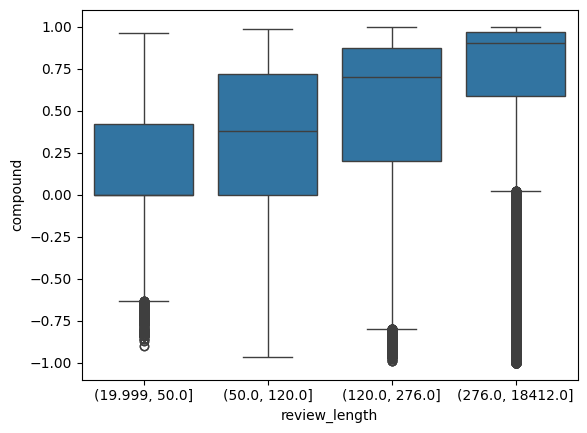

In [45]:
sns.boxplot(
    data=df,
    x=pd.qcut(df["review_length"], 4),
    y="compound"
)

<Axes: xlabel='mean_sentiment', ylabel='game_title'>

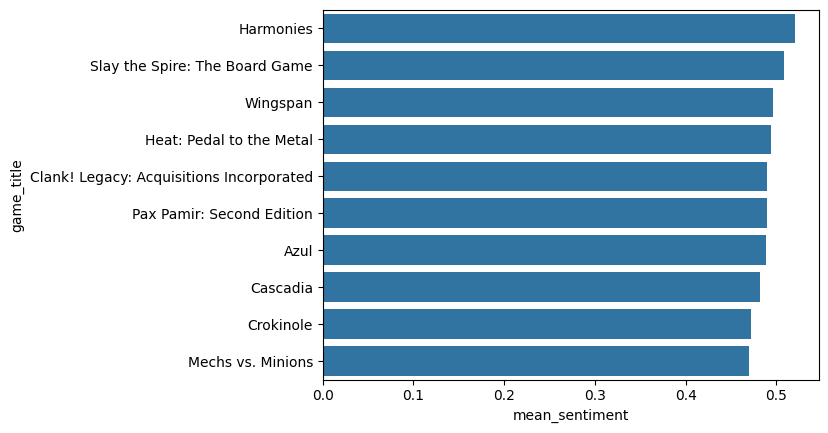

In [46]:
# chyba zbyt szcegółowe, nie znamy się tak na grach?
top_games = game_sentiment.sort_values(
    "mean_sentiment", ascending=False
).head(10)

sns.barplot(
    data=top_games,
    x="mean_sentiment",
    y="game_title"
)

In [50]:
# 1. Konwersja daty
df["review_date"] = pd.to_datetime(df["review_date"], errors="coerce")

# 2. Tworzymy kopię po usunięciu pustych dat - to KLUCZ do naprawy ostrzeżenia
df = df.dropna(subset=["review_date"]).copy()

# 3. Przypisujemy rok za pomocą .loc (bezpieczna metoda)
df.loc[:, "year"] = df["review_date"].dt.year.astype(int)

C:\Users\Dell\AppData\Local\Temp\ipykernel_3856\1370478839.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["review_date"] = pd.to_datetime(df["review_date"], errors="coerce")


In [51]:
yearly = (
    df.groupby("year")
      .agg(
          mean_compound=("compound", "mean"),
          total=("sentiment_label", "size"),
          pos=("sentiment_label", lambda x: (x == "positive").sum()),
          neu=("sentiment_label", lambda x: (x == "neutral").sum()),
          neg=("sentiment_label", lambda x: (x == "negative").sum()),
      )
      .reset_index()
)

# convert counts to percentages
yearly["pos_pct"] = yearly["pos"] / yearly["total"] * 100
yearly["neu_pct"] = yearly["neu"] / yearly["total"] * 100
yearly["neg_pct"] = yearly["neg"] / yearly["total"] * 100

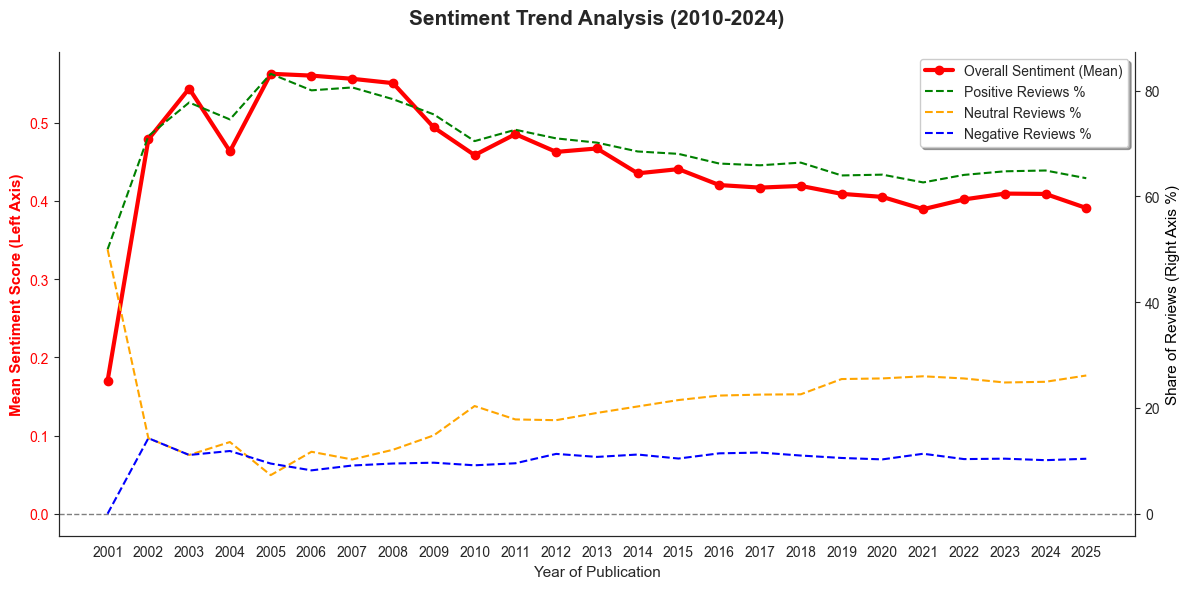

In [103]:


import matplotlib.pyplot as plt
import seaborn as sns

# Setup style
sns.set_style("white")
fig, ax1 = plt.subplots(figsize=(12, 6))

# 1. Left Axis: Mean Sentiment (Red line)
line1 = ax1.plot(yearly["year"], yearly["mean_compound"], 
                 marker="o", color="red", lw=3, label="Overall Sentiment (Mean)")
ax1.set_ylabel("Mean Sentiment Score (Left Axis)", color="red", fontsize=11, fontweight="bold")
ax1.tick_params(axis='y', labelcolor="red")
ax1.set_xlabel("Year of Publication", fontsize=11)
ax1.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)

# 2. Right Axis: Percentages (Dashed lines)
ax2 = ax1.twinx()
line2 = ax2.plot(yearly["year"], yearly["pos_pct"], linestyle="--", color="green", label="Positive Reviews %")
line3 = ax2.plot(yearly["year"], yearly["neu_pct"], linestyle="--", color="orange", label="Neutral Reviews %")
line4 = ax2.plot(yearly["year"], yearly["neg_pct"], linestyle="--", color="blue", label="Negative Reviews %")
ax2.set_ylabel("Share of Reviews (Right Axis %)", color="black", fontsize=11)

# 3. COMBINING LEGEND (Moved to Upper Right)
lines = line1 + line2 + line3 + line4
labels = [l.get_label() for l in lines]

# loc='upper right' places it in the corner
ax1.legend(lines, labels, loc='upper right', frameon=True, shadow=True)

plt.title("Sentiment Trend Analysis (2010-2024)", fontsize=15, weight="bold", pad=20)
plt.xticks(yearly["year"].astype(int)) 

sns.despine(right=False)
plt.tight_layout()
plt.show()

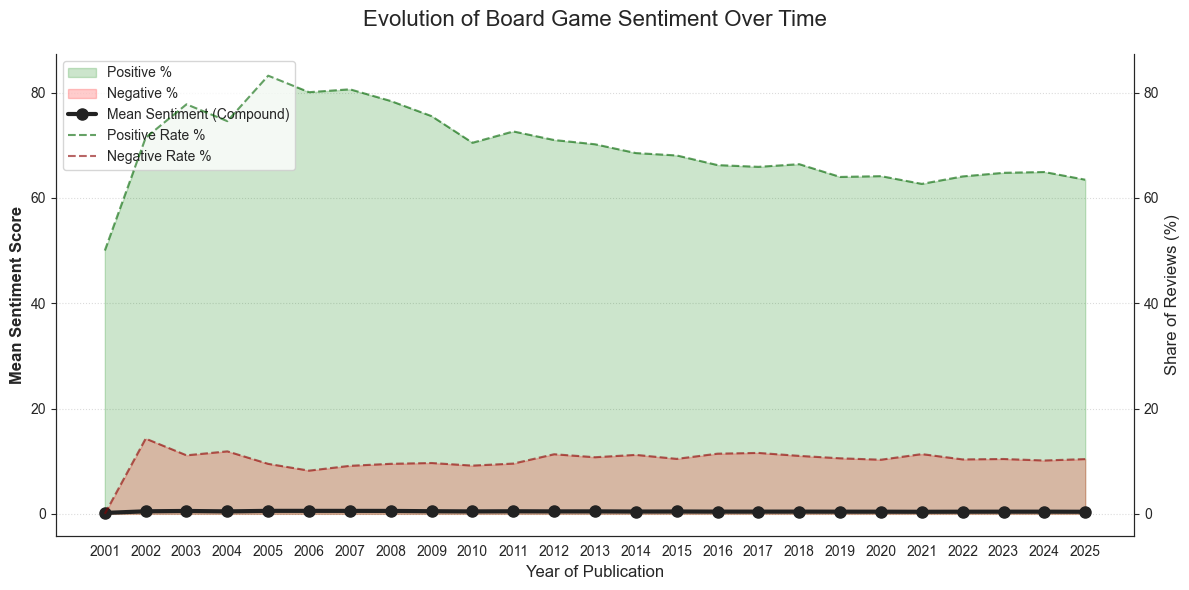

In [100]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ustawienie stylu
sns.set_style("white")
fig, ax1 = plt.subplots(figsize=(12, 6))

# 1. Rysujemy obszary procentowe (Stacked Area Chart lub słupki) - daje lepsze tło
ax1.fill_between(yearly["year"], yearly["pos_pct"], color="green", alpha=0.2, label="Positive %")
ax1.fill_between(yearly["year"], yearly["neg_pct"], color="red", alpha=0.2, label="Negative %")

# 2. Główna linia średniego sentymentu
ln1 = ax1.plot(yearly["year"], yearly["mean_compound"], marker="o", markersize=8, 
               color="#222222", linewidth=3, label="Mean Sentiment (Compound)")
ax1.set_ylabel("Mean Sentiment Score", fontsize=12, fontweight='bold')
ax1.set_xlabel("Year of Publication", fontsize=12)

# 3. Druga oś dla procentów (opcjonalnie, ale zróbmy to czytelniej)
ax2 = ax1.twinx()
ln2 = ax2.plot(yearly["year"], yearly["pos_pct"], color="darkgreen", linestyle="--", alpha=0.6, label="Positive Rate %")
ln3 = ax2.plot(yearly["year"], yearly["neg_pct"], color="darkred", linestyle="--", alpha=0.6, label="Negative Rate %")
ax2.set_ylabel("Share of Reviews (%)", fontsize=12)

# 4. Wykończenie i Legendy
plt.title("Evolution of Board Game Sentiment Over Time", fontsize=16, pad=20)
ax1.grid(axis='y', linestyle=':', alpha=0.7)

# Połączenie legend z obu osi
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left', frameon=True)

plt.xticks(yearly["year"].astype(int)) # Tylko pełne lata na osi X
sns.despine(right=False)
plt.tight_layout()
plt.show()

In [53]:
df.head()

,game_title,game_weight,avg_game_rating,review_text,review_rating,is_owner,review_date,sentiment_scores,compound,sentiment_label,tb_sentiment,tb_subjectivity,tb_polarity,tb_label,review_length,rating_bin,rating_group,length_bin,year
0,Brass: Birmingham,3.87,8.572,"Great game that somehow feels simple, yet ever...",8.5,False,2021-02-25 08:42:44,"{'neg': 0.0, 'neu': 0.745, 'pos': 0.255, 'comp...",0.6249,positive,0.133333,0.502381,0.133333,positive,80,"(8, 9]","[8, 10)","(50, 100]",2021
1,Brass: Birmingham,3.87,8.572,If you can play this in 60 minutes you're play...,9.4,True,2024-07-10 16:55:53,"{'neg': 0.0, 'neu': 0.779, 'pos': 0.221, 'comp...",0.8481,positive,0.080000,0.680000,0.080000,positive,217,"(9, 10]","[8, 10)","(200, 500]",2024
2,Brass: Birmingham,3.87,8.572,"I only played half a real game, but I was capt...",8.7,False,2025-11-10 19:17:57,"{'neg': 0.0, 'neu': 0.523, 'pos': 0.477, 'comp...",0.8020,positive,-0.255556,0.588889,-0.255556,negative,82,"(8, 9]","[8, 10)","(50, 100]",2025
3,Brass: Birmingham,3.87,8.572,"The more I play, the more I realize it's more ...",7.0,False,2022-11-18 00:53:44,"{'neg': 0.0, 'neu': 0.653, 'pos': 0.347, 'comp...",0.7889,positive,0.333333,0.391667,0.333333,positive,106,"(6, 7]","[6, 8)","(100, 200]",2022
4,Brass: Birmingham,3.87,8.572,Very good game. I might not say it is the best...,8.0,True,2024-11-26 12:06:53,"{'neg': 0.038, 'neu': 0.79, 'pos': 0.172, 'com...",0.9019,positive,0.278426,0.480053,0.278426,positive,398,"(7, 8]","[8, 10)","(200, 500]",2024


In [54]:
#prices

In [56]:
with (PATHS.data / "prices.json").open("rb") as f:
    prices = json.load(f)


In [58]:
price_rows = []

for item in prices:
    game_title = item["title"]
    for p in item["prices"]:
        price_rows.append({
            "game_title": game_title,
            "value": p["value"],
            "currency": p["currency"]
        })

df_prices = pd.DataFrame(price_rows)


In [64]:
currency_rates = {
    "$": 1.0,
    "€": 1.18,
    "£": 1.37
}


In [65]:
df_prices["price_usd"] = (
    df_prices["value"] * df_prices["currency"].map(currency_rates)
)


In [67]:
# Aggregate prices: we'll use the minimum price as the "market entry" price
game_price_agg = (
    df_prices.groupby("game_title")
    .agg(min_price_usd=("price_usd", "min"), avg_price_usd=("price_usd", "mean"))
    .reset_index()
)

# Merge with your existing game_sentiment dataframe
game_analysis = pd.merge(game_sentiment, game_price_agg, on="game_title", how="inner")

Correlation between Price and Sentiment: -0.01973721402140762


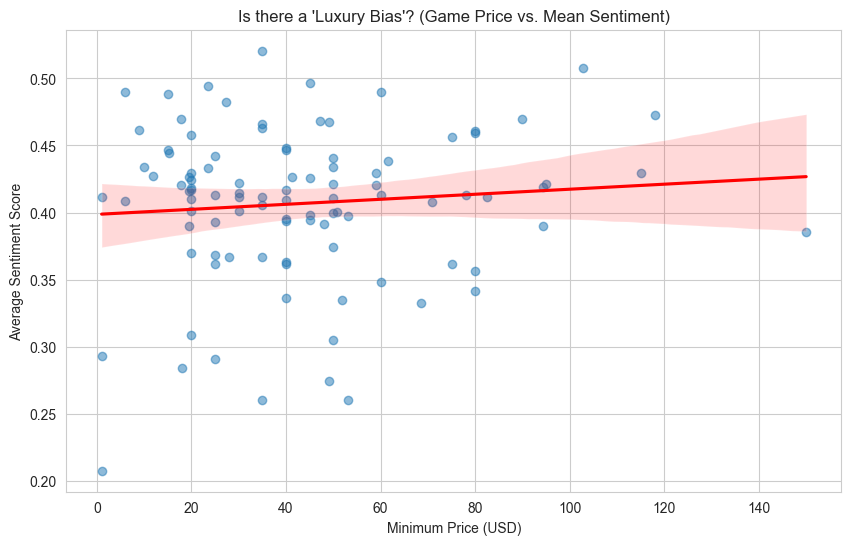

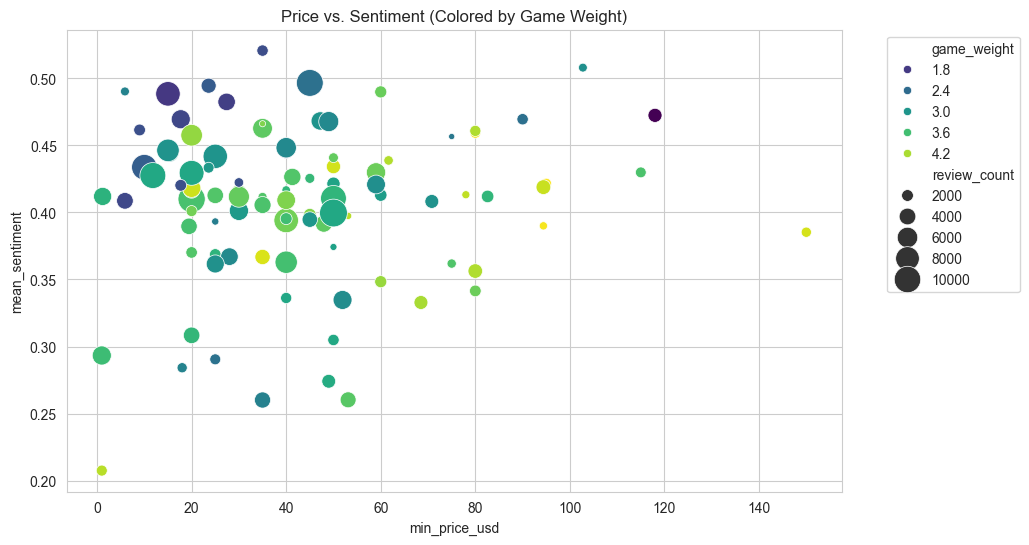

In [105]:
import seaborn as sns
import matplotlib.pyplot as plt

# Correlation check
price_corr = game_analysis[["min_price_usd", "mean_sentiment", "game_weight"]].corr(method="spearman")
print("Correlation between Price and Sentiment:", price_corr.loc["min_price_usd", "mean_sentiment"])

# Plot 1: Price vs Sentiment
plt.figure(figsize=(10, 6))
sns.regplot(data=game_analysis, x="min_price_usd", y="mean_sentiment", 
            scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title("Is there a 'Luxury Bias'? (Game Price vs. Mean Sentiment)")
plt.xlabel("Minimum Price (USD)")
plt.ylabel("Average Sentiment Score")
plt.show()

# Plot 2: Price vs Sentiment by Weight (Difficulty)
# This checks if expensive 'heavy' games are better received than expensive 'light' games
plt.figure(figsize=(10, 6))
sns.scatterplot(data=game_analysis, x="min_price_usd", y="mean_sentiment", 
                size="review_count", hue="game_weight", palette="viridis", sizes=(20, 400))
plt.title("Price vs. Sentiment (Colored by Game Weight)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

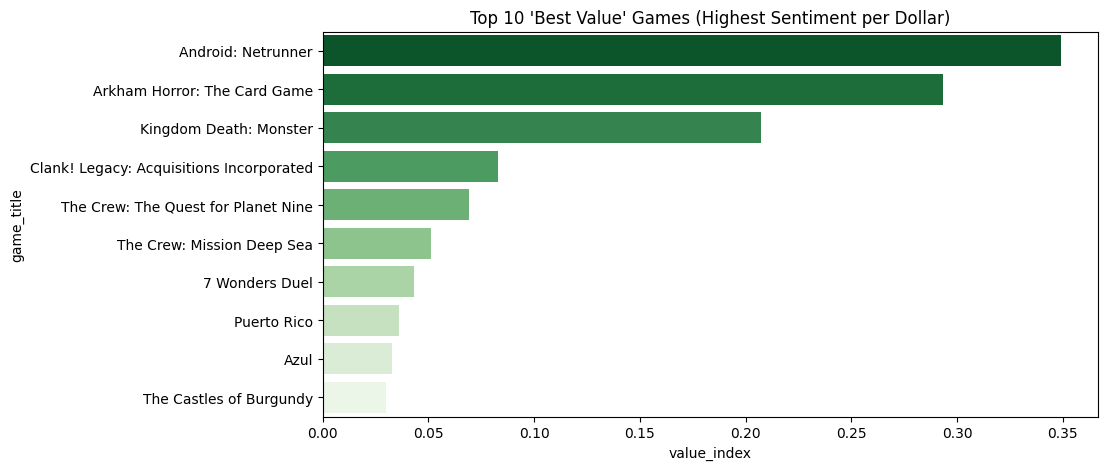

In [72]:
# Simple Value Index: Sentiment per Dollar
game_analysis["value_index"] = game_analysis["mean_sentiment"] / game_analysis["min_price_usd"]

top_value_games = game_analysis.sort_values("value_index", ascending=False).head(10)

plt.figure(figsize=(10, 5))
sns.barplot(
    data=top_value_games, 
    x="value_index", 
    y="game_title", 
    hue="game_title",      # Przypisujemy tytuł gry do koloru
    palette="Greens_r", 
    legend=False           # Wyłączamy legendę, bo dublowałaby napisy na osi Y
)
plt.title("Top 10 'Best Value' Games (Highest Sentiment per Dollar)")
plt.show()

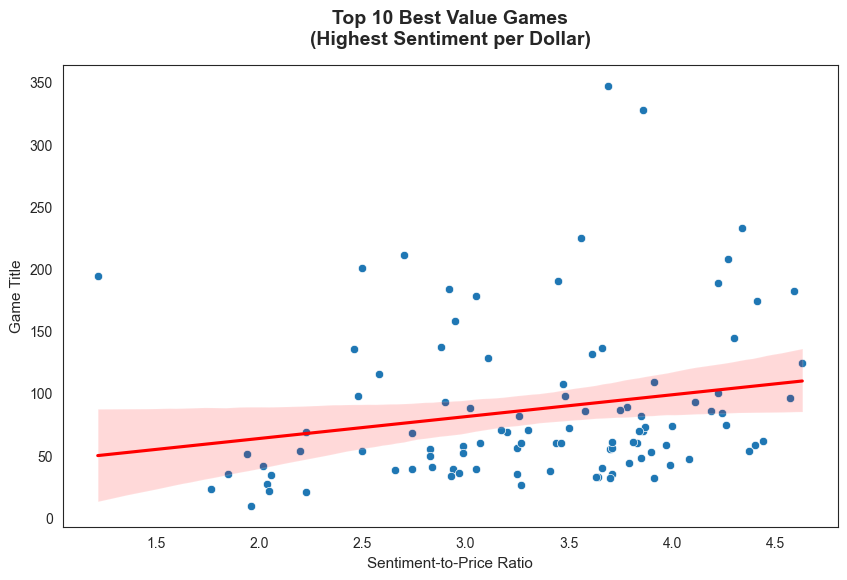

In [110]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=game_analysis, x="game_weight", y="avg_price_usd")
sns.regplot(data=game_analysis, x="game_weight", y="avg_price_usd", scatter=False, color="red")
# Tytuł główny
plt.title("Top 10 Best Value Games\n(Highest Sentiment per Dollar)", fontsize=14, fontweight='bold', pad=15)

# Opisy osi
plt.xlabel("Sentiment-to-Price Ratio", fontsize=11)
plt.ylabel("Game Title", fontsize=11)
plt.show()

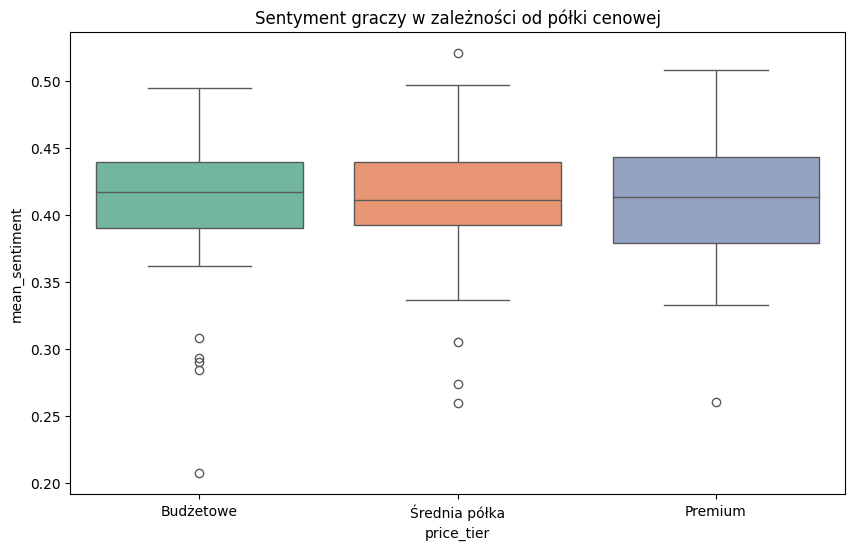

In [74]:
# Podział na 3 równe grupy pod względem ceny
game_analysis['price_tier'] = pd.qcut(game_analysis['min_price_usd'], q=3, labels=['Budżetowe', 'Średnia półka', 'Premium'])

plt.figure(figsize=(10, 6))
sns.boxplot(data=game_analysis, x='price_tier', y='mean_sentiment', hue='price_tier', palette="Set2", legend=False)
plt.title("Sentyment graczy w zależności od półki cenowej")
plt.show()

In [78]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# Zakładamy, że masz już tabelę 'game_analysis' z kolumnami 'mean_sentiment' i 'min_price_usd'
# Tworzymy kopię do rankingu
df_ranking = game_analysis.copy()

# Normalizacja (0-1)
df_ranking[['sent_norm', 'price_norm']] = scaler.fit_transform(
    df_ranking[['mean_sentiment', 'min_price_usd']]
)

# Wskaźnik opłacalności: wysoki sentyment (sent_norm) i niska cena (1 - price_norm)
df_ranking['value_score'] = (df_ranking['sent_norm'] + (1 - df_ranking['price_norm'])) / 2

# Rankingi
best_investments = df_ranking.sort_values("value_score", ascending=False).head(10)
expensive_disappointments = df_ranking.sort_values("value_score", ascending=True).head(10)

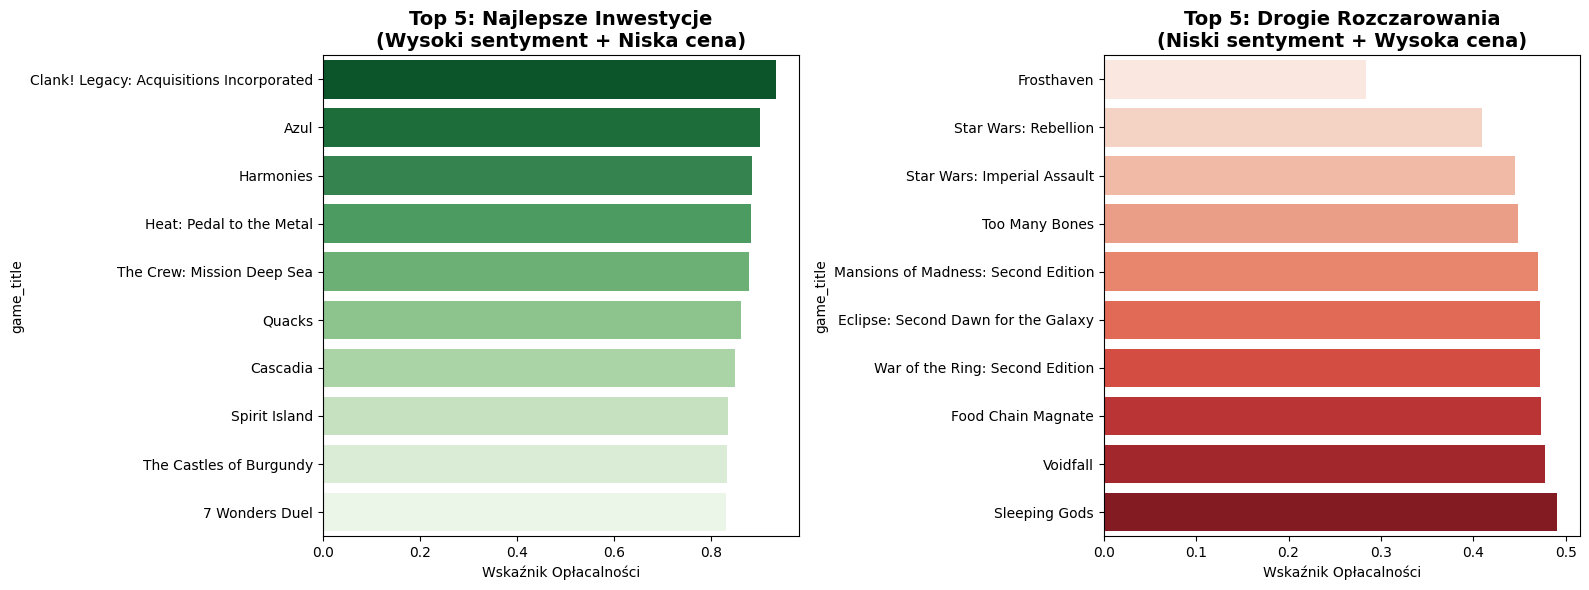

In [79]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Wykres 1: Najlepsze Inwestycje
sns.barplot(
    data=best_investments, 
    x="value_score", 
    y="game_title", 
    ax=axes[0], 
    hue="game_title",
    palette="Greens_r",
    legend=False
)
axes[0].set_title("Top 5: Najlepsze Inwestycje\n(Wysoki sentyment + Niska cena)", fontsize=14, fontweight='bold')
axes[0].set_xlabel("Wskaźnik Opłacalności")

# Wykres 2: Drogie Rozczarowania
sns.barplot(
    data=expensive_disappointments, 
    x="value_score", 
    y="game_title", 
    ax=axes[1], 
    hue="game_title",
    palette="Reds",
    legend=False
)
axes[1].set_title("Top 5: Drogie Rozczarowania\n(Niski sentyment + Wysoka cena)", fontsize=14, fontweight='bold')
axes[1].set_xlabel("Wskaźnik Opłacalności")

plt.tight_layout()
plt.show()

In [81]:
df.head()

,game_title,game_weight,avg_game_rating,review_text,review_rating,is_owner,review_date,sentiment_scores,compound,sentiment_label,tb_sentiment,tb_subjectivity,tb_polarity,tb_label,review_length,rating_bin,rating_group,length_bin,year
0,Brass: Birmingham,3.87,8.572,"Great game that somehow feels simple, yet ever...",8.5,False,2021-02-25 08:42:44,"{'neg': 0.0, 'neu': 0.745, 'pos': 0.255, 'comp...",0.6249,positive,0.133333,0.502381,0.133333,positive,80,"(8, 9]","[8, 10)","(50, 100]",2021
1,Brass: Birmingham,3.87,8.572,If you can play this in 60 minutes you're play...,9.4,True,2024-07-10 16:55:53,"{'neg': 0.0, 'neu': 0.779, 'pos': 0.221, 'comp...",0.8481,positive,0.080000,0.680000,0.080000,positive,217,"(9, 10]","[8, 10)","(200, 500]",2024
2,Brass: Birmingham,3.87,8.572,"I only played half a real game, but I was capt...",8.7,False,2025-11-10 19:17:57,"{'neg': 0.0, 'neu': 0.523, 'pos': 0.477, 'comp...",0.8020,positive,-0.255556,0.588889,-0.255556,negative,82,"(8, 9]","[8, 10)","(50, 100]",2025
3,Brass: Birmingham,3.87,8.572,"The more I play, the more I realize it's more ...",7.0,False,2022-11-18 00:53:44,"{'neg': 0.0, 'neu': 0.653, 'pos': 0.347, 'comp...",0.7889,positive,0.333333,0.391667,0.333333,positive,106,"(6, 7]","[6, 8)","(100, 200]",2022
4,Brass: Birmingham,3.87,8.572,Very good game. I might not say it is the best...,8.0,True,2024-11-26 12:06:53,"{'neg': 0.038, 'neu': 0.79, 'pos': 0.172, 'com...",0.9019,positive,0.278426,0.480053,0.278426,positive,398,"(7, 8]","[8, 10)","(200, 500]",2024
